Formation OpenClassrooms DS-IML - **Marc Lefèvre**, <marc.lefevre@noos.fr>

# **Projet 5 : Catégorisation de questions Stack Overflow**

## **3ème partie : Word Embedding & piste du Deep Learning**

## **Opérations préliminaires**

### **Importation des bibliothèques python utiles**

In [33]:
import pandas as pd
import pickle
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import gensim
import nltk
import tensorflow as tf

from gensim.models.fasttext import FastText
from gensim.test.utils import get_tmpfile
from tqdm.notebook import trange, tqdm

from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_validate, cross_val_score, learning_curve
from sklearn.manifold import TSNE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

from bayes_opt import BayesianOptimization
from skmultilearn.problem_transform import BinaryRelevance

# Ignorance de certains avertissements
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## **Fonctions utiles**

**Traitement données texte**

In [15]:
def clean_text(texte):
    
    char_gardes = r'[^a-z#+.\s]'
    return re.sub(char_gardes, '', texte)  


def remove_sw(texte, return_verbs, return_token):
    
    doc = nlp(texte)
    
    if return_verbs :
    
        tokens = [token for token in doc if \
                  token.is_stop == False and token.is_punct == False\
                  and token.is_space == False
                 ]
    
    else :
        
        tokens = [token for token in doc if \
                  token.is_stop == False and token.is_punct == False\
                  and token.pos_ != "VERB"\
                  and token.is_space == False
                 ]
    
    if return_token :
        
        return tokens
    
    txt = ""
    
    for t in tokens :
        
        txt = txt + " " + t.text
        txt = txt.lstrip()
        
    return txt


def pipe_clsw(texte, return_verbs = True, return_token = True):
    """
    Nettoye et enlève les SW d'un text/str et retourne une liste de tokens.
    Par défaut : 
    - On garde les verbe. Si False on les élimine du résultat.
    - On retourne une liste de tokens. Si False on retourne une "str".
    """
    
    res = remove_sw(clean_text(texte), return_verbs, return_token)
    
    return res

**Représentations graphiques**

In [16]:
def c_tsne(df_coord, perp) :
    """
    
    """
    
    start = time()

    tsne = TSNE(n_components=2, init='pca', perplexity = perp, random_state = 47)
    red_tsne = tsne.fit_transform(df_coord)
    red_tsne = StandardScaler().fit_transform(red_tsne)
    df_tsne = pd.DataFrame(red_tsne, columns = ["tsne_1", "tsne_2"])
    
    return df_tsne

def fullGraph(df_tsne, df_targ, size, titre):    
    
    #df_tsne = c_tsne(df_coord, complexity)
    
    plt.figure(figsize = size)
    #plt.grid()
    sns.set_style("whitegrid")

    
    for col in df_targ.columns :
        
        plt.scatter(df_tsne.tsne_1[df_targ[col] == 1],
                    df_tsne.tsne_2[df_targ[col] == 1],
                    color= plt.cm.Set1(df_targ.columns.tolist().index(col) / float(len(df_targ.columns))),
                    label = col,
                    marker='o',
                    s = 4,
                    linewidth=1,
                    alpha = 1
                   )
        
    plt.legend(bbox_to_anchor=(1.01, 1), fontsize='large')
    plt.title(titre, fontsize='large')
    plt.show()
    
    
def annotgraph(df_tsne, df_targ, size, titre) :
    
    #df_te = c_tsne(df_coord, complexity)
    df_rep = df_targ.join(df_tsne)
    
    liste = []

    for col in df_targ.columns :
        liste.append(df_rep[df_tsne.columns][df_rep[col] == 1].mean())
        
    df_mean = pd.DataFrame(liste)
    df_mean["tag"] = df_targ.columns.tolist()
    
    plt.figure(figsize = size)
    #plt.grid()
    sns.set_style("darkgrid")
    
    sns.scatterplot(x = "tsne_1", 
                    y = "tsne_2",
                    hue = df_mean.tag,
                    data = df_mean,
                    legend = None,
                    alpha = 1
                    )
    
    
    for i, val in df_mean.iterrows():
        
        if val[2] in ["php", "laravel"] :
            
            plt.annotate(val[2],
                         val[:2],
                         xytext=(-5, 10),
                         textcoords='offset pixels',
                         ha='right')

        else :

            plt.annotate(val[2], 
                         val[:2],
                         xytext=(10, 10),
                         textcoords='offset pixels',
                         ha='center')
        
    plt.title(titre, fontsize='large')
    plt.show()

**Modélisation**

In [17]:
def modeli(n, X_train, y_train, X_test, y_test):
    """
    Fonction de modélisation prenant en paramètre le nombre "n" de composants d'une PCA
    """
    
    start = time()
    
    pca = PCA(n_components = n)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    xgb_model = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47)
    m_class = BinaryRelevance(classifier = xgb_model).fit(X_train_pca, y_train)
    pred_train = m_class.predict(X_train_pca)
    pred_test = m_class.predict(X_test_pca)
    
    score_train = f1_score(y_train, pred_train, average = "weighted")
    score_test = f1_score(y_test, pred_test, average = "weighted")
    
    temps = (time() - start)
    
    return (score_train, score_test, temps)




def modelize(n, X_train, y_train, X_test, y_test):
    """
    Fonction similaire à la précédente qui renvoie en plus la variance expliquée des données par le
    nombre de composants "n" de la PCA.
    """
    
    start = time()
    
    pca = PCA(n_components = n)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    xgb_model = xgb.XGBClassifier()
    m_class = BinaryRelevance(classifier = xgb_model).fit(X_train_pca, y_train)
    pred_train = m_class.predict(X_train_pca)
    pred_test = m_class.predict(X_test_pca)
    
    score_train = f1_score(y_train, pred_train, average = "weighted")
    score_test = f1_score(y_test, pred_test, average = "weighted")
    
    explained_variance = pca.explained_variance_ratio_.sum()*100
    
    temps = (time() - start)
    
    return (score_test, explained_variance, temps)



def model_pca(liste, X_train, y_train, X_test, y_test):
    """
    Fonction similaire à la précédente en fonction d'une liste de composants "n".
    """
    
    score = []
    explained_variance = []
    temps = []
    
    for n in liste :
        
        results = (modelize(n, X_train, y_train, X_test, y_test))
        score.append(results[0])
        explained_variance.append(results[1])
        temps.append(results[2])
        
    best_index = np.argmax(score)
    
    print(f"Meilleur score {score[best_index]:.2f} pour PCA avec n = {liste[best_index]} expliquant {explained_variance[best_index]:.0f}% de la variance en {temps[best_index]:.0f} secondes.")
    return(score[best_index], liste[best_index], explained_variance[best_index], temps[best_index])

**Word embedding**

In [18]:
def make_gensim_vectors(corpus, model) :
    """
    Fonction de vectorisation de données texte par un modèle "word2vec".
    """
    
    liste_vect_totale = []
    
    for texte in corpus:
        
        list_vect_text = []
        
        for mot in texte :
            
            list_vect_text.append(model[mot])
        
        list_vect_text = np.array(list_vect_text)
        vect_text = np.mean(list_vect_text, axis = 0)
        
            
        liste_vect_totale.append(vect_text)
        
    return np.array(liste_vect_totale)

def text_from_tok(corpus):
    """
    Fonction d'extraction de données texte à partir de tokens.
    """
    
    new_corpus = []
    
    for quest in corpus :
        
        new_quest = [tok.text for tok in quest]
        new_corpus.append(new_quest)
        
    return new_corpus


def clean_for_gensim(corpus, lexique):
    """
    Fonction servant à enlever d'un texte les mots ne figurant pas dans le "vocabulaire" d'un modèle
    word2vec.
    """
    
    clean_corpus = []
    
    for texte in corpus :
        
        new_text = []
        
        for w in texte :
            
            if w in lexique :
                
                new_text.append(w)
        
        # pour éviter l'ajout d'une valeur NAN à notre tableau...
        if len(new_text) == 0 :
            clean_corpus.append('error')
        else :
            clean_corpus.append(new_text)   
        
    return clean_corpus

**Classe SO_Tag_Predictor**

Classe à partir de laquelle utiliser le "prédicteur de tag" final de notre projet.

In [ ]:
class SO_Tag_Predictor() :
    """
    Utilisation :
    predictor = SO_Tag_Predictor()
    prediction = predictor.tag_one_question("texte de la question")
    print(prediction)
    """
    
    
    def __init__(self):

        self.model_w2v = FastText.load("Data/model_ft.bin")
        self.model = self.create_model()
        self.nlp = spacy.load('en_core_web_sm')
        self.std = pickle.load(open("Data/std.pickle", "rb"))
        self.pca = pickle.load(open("Data/pca.pickle", "rb"))
        self.labels = pickle.load(open("Data/labels.pickle", "rb"))
    
    
    def tag_one_question(self, texte):
        
        t = self.soup_text(texte)
    
        tx = self.pipe_clsw(t, True, True)
    
        txt = self.text_from_tok([tx])

        tx_we = self.make_gensim_vectors(txt, self.model_w2v)

        tx_std = self.std.transform(tx_we)

        tx_pca = self.pca.transform(tx_std)

        pred = self.model.predict(tx_pca)
        
        # On force la prédiction
        res = []

        if (pred > 0.5).sum() == 0 :

            res.append(labels[np.argmax(pred)])

        else :

            pred = pred.round()

            for n in np.nonzero(pred)[1].tolist():

                res.append(self.labels[n])

        return res
    
 
    def create_model(self):

        model = Sequential()

        model.add(Dense(75, input_shape = (75, )))
        model.add(Activation("relu"))
        model.add(Dropout(0.2))

        model.add(Dense(75))
        model.add(Activation("relu"))

        model.add(Dense(25))
        model.add(Activation("sigmoid"))

        model.compile(loss='binary_crossentropy', optimizer="adam", metrics="accuracy")

        model.load_weights("Data/so_dl_01.hdf5")

        return model
    
    
    def soup_text(self, t):
    
        liste_sans_pre = []
        texte = ""

        soup = soupe(t)

        for cont in soup :

            if not cont.name or cont.name != "pre":

                liste_sans_pre.append(cont)

        for c in liste_sans_pre :

            if isinstance(c, bs4.element.Tag):

                texte = texte + c.text.replace("\n", "") + " "

            else :

                texte = texte + c.replace("\n", "") + " "

        texte = texte.rstrip()

        return texte.lower()   
    

    def clean_text(self, texte):

        char_gardes = r'[^a-z#+.\s]'
        return re.sub(char_gardes, '', texte)  

    
    def remove_sw(self, texte, return_verbs, return_token):

        doc = self.nlp(texte)

        if return_verbs :

            tokens = [token for token in doc if \
                      token.is_stop == False and token.is_punct == False\
                      and token.is_space == False
                     ]

        else :

            tokens = [token for token in doc if \
                      token.is_stop == False and token.is_punct == False\
                      and token.pos_ != "VERB"\
                      and token.is_space == False
                     ]

        if return_token :

            return tokens

        txt = ""

        for t in tokens :

            txt = txt + " " + t.text
            txt = txt.lstrip()

        return txt


    def pipe_clsw(self, texte, return_verbs = True, return_token = True):

        res = self.remove_sw(self.clean_text(texte), return_verbs, return_token)

        return res


    def make_gensim_vectors(self, corpus, model) :

        liste_vect_totale = []

        for texte in corpus:

            list_vect_text = []

            for mot in texte :

                list_vect_text.append(model[mot])

            list_vect_text = np.array(list_vect_text)
            vect_text = np.mean(list_vect_text, axis = 0)


            liste_vect_totale.append(vect_text)

        return np.array(liste_vect_totale)

    
    def text_from_tok(self, corpus):
    
        new_corpus = []

        for quest in corpus :

            new_quest = [tok.text for tok in quest]
            new_corpus.append(new_quest)

        return new_corpus


    def clean_for_gensim(self, corpus, lexique):

        clean_corpus = []

        #lex = model_google.vocab.keys()

        for texte in corpus :

            new_text = []

            for w in texte :

                if w in lexique :

                    new_text.append(w)

            # pour éviter l'ajout d'une valeur NAN à notre tableau...
            if len(new_text) == 0 :
                clean_corpus.append('error')
            else :
                clean_corpus.append(new_text)   

        return clean_corpus

# **1-) Non pertinence d'une approche 100% supervisée**

A partir des données texte vectorisées TF, voyons si un moyen de réduction dimensionnelle comme la PCA pourrait nous permettre d'obtenir des réductions satisfaisantes...

In [2]:
feat_train_vect = pickle.load(open("Data/feat_train_vect.pickle", "rb"))
feat_test_vect = pickle.load(open("Data/feat_test_vect.pickle", "rb"))

y_train = pickle.load(open("Data/y_train.pickle", "rb"))
y_test = pickle.load(open("Data/y_test.pickle", "rb"))

In [3]:
feat_train_vect.shape

(20000, 4789)

Comme nous le voyons, en l'état ces données vectorisées TF sont de dimension 20000x**4789**.

**Normalisation**

In [548]:
std = StandardScaler().fit(feat_train_vect.toarray())
feat_train_scaled = std.transform(feat_train_vect.toarray())
feat_test_scaled = std.transform(feat_test_vect.toarray())

### **PCA**

In [549]:
for n in [5, 10, 100, 500, 1000]:
    pca = PCA(n_components = n)
    pca.fit(feat_train_scaled)
    print(f"Pour n = {n}, la PCA explique {pca.explained_variance_ratio_.sum()} % de la variance des données")    

Pour n = 5, la PCA explique 0.015275843166922688 % de la variance des données
Pour n = 10, la PCA explique 0.02460407690061692 % de la variance des données
Pour n = 100, la PCA explique 0.1061283353918617 % de la variance des données
Pour n = 500, la PCA explique 0.29765390655260965 % de la variance des données
Pour n = 1000, la PCA explique 0.469105218599058 % de la variance des données


Une réduction en **1000** composants principaux n'explique que **47%** de la variance des données.<br>Manifestement la PCA ne va pas nous permettre de réduire suffisamment le nombre de dimension de nos données. Il va nous falloir trouver un autre moyen de modélisation/vectorisation de notre texte, qui est le **word_embedding**.

# **2-) Word Embedding**

Le **word embedding**

### **1-) Préparation**

In [107]:
feat = pickle.load(open("Data/X.pickle", "rb"))
cible = pickle.load(open("Data/y.pickle", "rb"))

feat_train = feat[:20000]
feat_test = feat[20000:]

In [556]:
# on garde les verbes, mais on veut le résultat en "string"
now = time()
feat_train_clean = [pipe_clsw(t, True, False) for t in feat_train]
feat_test_clean = [pipe_clsw(t, True, False) for t in feat_test]
print(f"Ce travail de nettoyage a pris {time() - now:.0f} secondes.")

Ce travail de nettoyage a pris 504 secondes.


In [58]:
feat_train_clean[1]

'spring boot controller content negotiation simple rest controller written springboot application sure implement content negotiation return json xml based contenttype parameter request header explain wrong controller method json calling method specify contenttype applicationxml textxml implement methods different mapping different content type able xml xml work specify mediatypes single method like provided example like message endpoint receive xml contenttype request set applicationxmljson contenttype applicationjson help appreciated editi updated controller accept media types'

In [59]:
pickle_out = open("Data/feat_train_clean.pickle", "wb")
pickle.dump(feat_train_clean, pickle_out)
pickle_out.close()

pickle_out = open("Data/feat_test_clean.pickle", "wb")
pickle.dump(feat_test_clean, pickle_out)
pickle_out.close()

### **2-) Modèle pré-entraîné SpaCy**

In [85]:
feat_train_clean = pickle.load(open("Data/feat_train_clean.pickle", "rb"))
feat_test_clean = pickle.load(open("Data/feat_test_clean.pickle", "rb"))

In [21]:
# chargement du modèle
nlp = spacy.load('en_core_web_lg')

L'opération suivante crée des vecteurs pour chaque texte (question...). Un vecteur représentant un texte étant la moyenne des vecteurs des ses mots.

In [61]:
# transformation du corpus
now = time()
X_train_spacy = np.array([nlp(w).vector for w in feat_train_clean])
X_test_spacy = np.array([nlp(w).vector for w in feat_test_clean])
print(f"Cette transformation Word-Embedding avec Spacy a pris {time() - now:.0f} secondes.")

Cette transformation Word-Embedding avec Spacy a pris 291 secondes.


In [65]:
# Sauvegarde
pickle_out = open("Data/X_train_spacy.pickle", "wb")
pickle.dump(X_train_spacy, pickle_out)
pickle_out.close()

pickle_out = open("Data/X_test_spacy.pickle", "wb")
pickle.dump(X_test_spacy, pickle_out)
pickle_out.close()

**Représentation graphique**

Afin d'illustrer, au propre comme au figuré, le fait que le **word-embedding** permette de représenter le sens des mots, et la proximité sémantique de mots ou de textes, voici des représentations graphiques de **réductions T-SNE** à deux dimensions de nos données d'entrainement en fonction des tags cibles.

In [9]:
df_coord_spacy = pd.DataFrame(X_train_spacy)

df_targ = pickle.load(open("Data/df_targ.pickle", "rb"))

df_tsne_spacy = c_tsne(df_coord_spacy, 60)

# Sauvegarde
pickle_out = open("Data/df_tsne_spacy.pickle", "wb")
pickle.dump(df_tsne_spacy, pickle_out)
pickle_out.close()

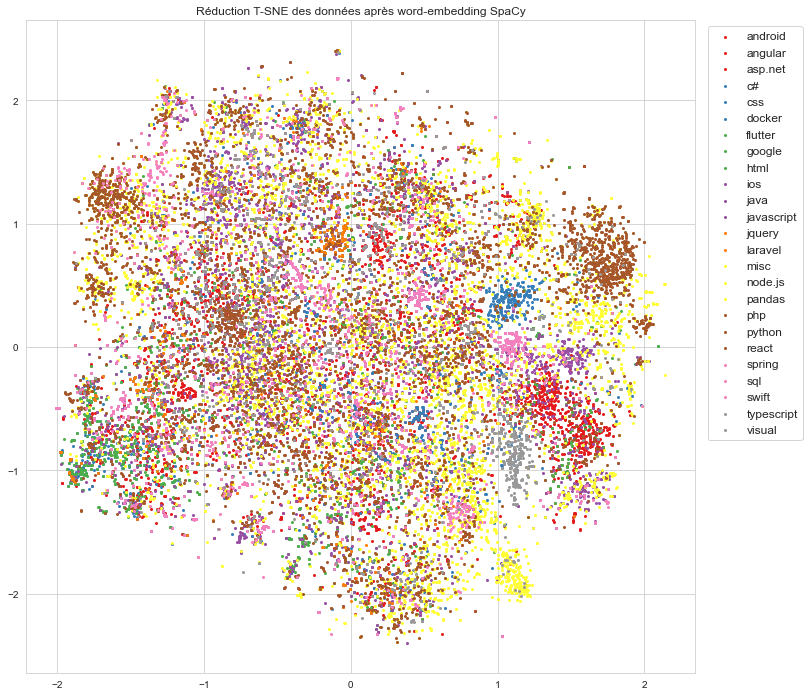

In [10]:
titre = "Réduction T-SNE des données après word-embedding SpaCy"

fullGraph(df_tsne_spacy, df_targ, (12, 12), titre)

On observe bien des "nuages" ou regroupements de points par couleurs, qui montrent bien que les tags, pour peu qu'ils ne soient pas trop généralistes, correspondent bien à des proximités sémantiques des questions.

Voici maintenant une représentation **annotée** des positions moyennes des questions en fonctions de leurs tags.

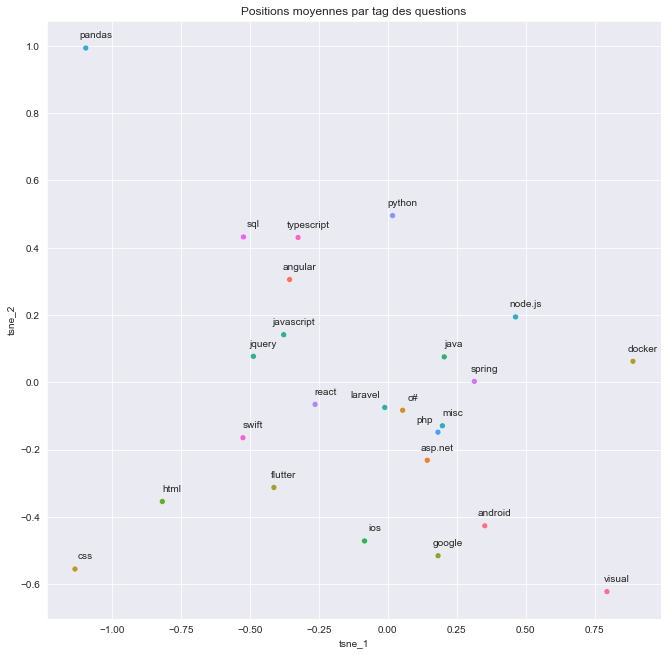

In [17]:
titre = "Positions moyennes par tag des questions"

annotgraph(df_tsne_spacy, df_targ, (11, 11), titre)

In [79]:
X_train_spacy = pickle.load(open("Data/X_train_spacy.pickle", "rb"))
X_test_spacy = pickle.load(open("Data/X_test_spacy.pickle", "rb"))

y_train = pickle.load(open("Data/y_train.pickle", "rb"))
y_test = pickle.load(open("Data/y_test.pickle", "rb"))

**PCA**

300 dimensions c'est encore beaucoup, nous allons réutiliser la **PCA** pour réduire autant que possible ce nombre.

In [80]:
std = StandardScaler().fit(X_train_spacy)
X_train_spacy_scaled = std.transform(X_train_spacy)
X_test_spacy_scaled = std.transform(X_test_spacy)

In [81]:
for n in [5, 10, 50, 100, 150, 200, 250, 300]:
    pca = PCA(n_components = n)
    pca.fit(X_train_spacy_scaled)
    print(f"Pour n = {n}, la PCA explique {pca.explained_variance_ratio_.sum()*100:.2f}% de la variance des données")    

Pour n = 5, la PCA explique 25.85% de la variance des données
Pour n = 10, la PCA explique 37.20% de la variance des données
Pour n = 50, la PCA explique 69.13% de la variance des données
Pour n = 100, la PCA explique 83.69% de la variance des données
Pour n = 150, la PCA explique 91.33% de la variance des données
Pour n = 200, la PCA explique 95.92% de la variance des données
Pour n = 250, la PCA explique 98.74% de la variance des données
Pour n = 300, la PCA explique 100.00% de la variance des données


Essayons maintenant des modélisations en fonction de **n**.

In [564]:
results = []

for n in [5, 10, 50, 100, 150, 200, 250, 300]:
    
    results.append(modeli(n, X_train_spacy_scaled, y_train, X_test_spacy_scaled, y_test))

In [565]:
results

[(0.49105134675565815, 0.12177014009088197, 17.12490439414978),
 (0.7679166809445286, 0.20116912171203344, 38.73817706108093),
 (0.9854032771173125, 0.45523751217096536, 91.83217239379883),
 (0.9954944761764153, 0.492971131240814, 162.19306993484497),
 (0.9983642516680047, 0.4944033544166741, 244.68287134170532),
 (0.9992426381624344, 0.48642340201136525, 319.33326482772827),
 (0.9996602350529881, 0.4867507452259863, 423.03519654273987),
 (0.9997925033389263, 0.4821342713785624, 463.70052218437195)]

Les prochaines fois, nous utiliserons le duo de fonctions **modelize** et **model_pca** pour effectuer ce type de démarche plus rapidement.

**Optimisation bayesiène pour N=150**

In [567]:
pca = PCA(n_components = 150)
pca.fit(X_train_spacy_scaled)
X_train_spacy_pca = pca.transform(X_train_spacy_scaled)
X_test_spacy_pca = pca.transform(X_test_spacy_scaled)

In [569]:
# sauvegardes
pickle_out = open("Data/X_train_spacy_pca.pickle", "wb")
pickle.dump(X_train_spacy_pca, pickle_out)
pickle_out.close()

pickle_out = open("Data/X_test_spacy_pca.pickle", "wb")
pickle.dump(X_test_spacy_pca, pickle_out)
pickle_out.close()

In [570]:
now = time()
xgb_model = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47)
m_class_spacy = BinaryRelevance(classifier = xgb_model).fit(X_train_spacy_pca, y_train)
print(f"l'entrainement a pris {time() - now:.0f} secondes")

l'entrainement a pris 234 secondes


In [571]:
preds = m_class_spacy.predict(X_test_spacy_pca)

f1_score(y_test, 
         preds, 
         average = "weighted")

0.49479086434200414

248 secondes pour une modélisation... Pour un résultat bien meilleure que ce qu'on a eu avant. On va tenter une recherche des meilleurs hyper-paramètres avec la méthode BO, et **sans** validation croisée.

In [572]:
def bo_m_clas3(max_depth, gamma, n_estimators ,learning_rate, eta):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate,
              'subsample': 0.8,
              'eta': eta, 
              'verbosity': 0, 
              'objective': "reg:logistic",
              'random_state' : 47#, 'eval_metric': 'f1'
             }
    
    # création du model qu'on va utiliser
    xgb_model = xgb.XGBClassifier(**params)
    # création du modèle multilabels
    m_clas = BinaryRelevance(classifier = xgb_model)
    
    m_clas.fit(X_train_spacy_pca, y_train)
    preds = m_clas.predict(X_test_spacy_pca)

    score = f1_score(y_test, preds, average = "weighted")
    
    return score

In [576]:
m_clas_bo3 = BayesianOptimization(bo_m_clas3, 
                                  {'max_depth': (3, 10),
                                   'gamma': (0.01, 0.99),
                                   'eta' : (0.01, 0.1),
                                   'learning_rate':(0.01, 0.99),
                                   'n_estimators':(50, 250)}, 
                                  random_state = 47)

In [577]:
start = time()
m_clas_bo3.maximize(n_iter=10, init_points=5, acq='ucb')
print(f"L'optimization a mis : {time() - start:.0f} secondes.")

|   iter    |  target   |    eta    |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.5169   |  0.02021  |  0.965    |  0.7242   |  5.46     |  191.5    |
|  2        |  0.497    |  0.08196  |  0.6427   |  0.4163   |  7.942    |  99.33    |
|  3        |  0.4985   |  0.03304  |  0.03353  |  0.1068   |  5.103    |  178.2    |
|  4        |  0.5273   |  0.039    |  0.1918   |  0.9088   |  4.896    |  104.7    |
|  5        |  0.5396   |  0.0959   |  0.1346   |  0.7423   |  3.037    |  221.4    |
|  6        |  0.4895   |  0.07494  |  0.8244   |  0.2579   |  6.918    |  77.88    |
|  7        |  0.5448   |  0.04988  |  0.39     |  0.3804   |  3.126    |  209.4    |
|  8        |  0.4983   |  0.07489  |  0.9617   |  0.9789   |  5.107    |  206.2    |
|  9        |  0.4906   |  0.02183  |  0.5765   |  0.8604   |  8.792    |  187.4    |
|  10       |  0.5421   |  0.06734  |  0.4777   |  0.3

In [578]:
best_params_03 = m_clas_bo3.max['params']
best_params_03

{'eta': 0.04988373441772504,
 'gamma': 0.3899916719809835,
 'learning_rate': 0.3803697026606988,
 'max_depth': 3.125741502716014,
 'n_estimators': 209.3536693510256}

In [579]:
best_params_03['max_depth']= int(best_params_03['max_depth'])
best_params_03['n_estimators']= int(best_params_03['n_estimators'])

In [580]:
xgb_model3 = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47, **best_params_03)
# création du modèle multilabels
m_clas3 = BinaryRelevance(classifier = xgb_model3)

In [581]:
start = time()
m_clas3.fit(X_train_spacy_pca, y_train)
print(f"L'entrainement a pris {time() - start:.0f} secondes")

L'entrainement a pris 264 secondes


In [582]:
pred_03 = m_clas3.predict(X_test_spacy_pca).toarray()
f1_score(y_test, 
         pred_03, 
         average = "weighted")

0.5406152229890178

In [583]:
# Sauvegardes

pickle_out = open("Data/m_clas3.pickle", "wb")
pickle.dump(m_clas3, pickle_out)
pickle_out.close()

pickle_out = open("Data/best_params_03.pickle", "wb")
pickle.dump(best_params_03, pickle_out)
pickle_out.close()

pickle_out = open("Data/pred_03.pickle", "wb")
pickle.dump(pred_03, pickle_out)
pickle_out.close()

**CRITIQUE**<br>Lors de la vectorisation des questions, le modèle spacy fonctionne en ignorant les mots qui ne sont pas dans son glossaire. Cherchons les...

In [83]:
# lexique de notre modèle :
lexique = list(nlp.vocab.strings)

print(f"Notre modèle spaCy contient {len(lexique)} 'mots' ou monogrammes différents")

Notre modèle spaCy contient 1476296 'mots' ou monogrammes différents


Recherchons combien de mots de nos données ont été ignorés par le modèle.

In [88]:
mots_hors_vocab = []
mots = []

start = time()

for elt in feat_train_clean :
    
    for w in nlp(elt) :
        
        mots.append(w.text)
        
        if w.has_vector == False :
            
            mots_hors_vocab.append(w.text)
            
mhv_uniques = list(set(mots_hors_vocab))
mots_uniques = list(set(mots))

temps = time() - start

print(f"Nombre de mots uniques non pris en compte : {len(mhv_uniques)} sur {len(mots_uniques)} mots au total.")
print(f"C'est à dire {(len(mhv_uniques) / len(mots_uniques))*100:.2f}% du vocabulaire de notre corpus.")
print(f"Ce décompte a pris {temps:.0f}sec.")

Nombre de mots uniques non pris en compte : 46269 sur 62209 mots au total.
C'est à dire 74.38% du vocabulaire de notre corpus.
Ce décompte a pris 237sec.


Exemples de mots non pris en compte...

In [162]:
mhv_uniques[2000:2010]

['nrfnr',
 'liptk',
 'sun.security.jgss.gsscredentialimpl.addgsscredentialimpl.java',
 'httpcodepen.ioanonpendovzdq',
 'object.why',
 'xlintunchecked',
 'car.color',
 'printfstring',
 'qwe.jpg.how',
 'efficientlyany']

C'est problématique car même avec des résultats encourageants, et même si les mots mis de côté sont d'un registre technique poussé ou concernent du code informatique, on a manifestement perdu beaucoup d'information...

Nous allons essayer maintenant le **words embeding Gensim**.

### **3-) Modèle word2vec pré-entrainé GoogleNews**

In [26]:
model_google = gensim.models.KeyedVectors.load_word2vec_format('Data/GoogleNews-vectors-negative300.bin', binary=True)

In [10]:
feat_train_gens_tk = [pipe_clsw(t, True, True) for t in feat_train]
feat_test_gens_tk = [pipe_clsw(t, True, True) for t in feat_test]

In [51]:
# Nous devons extraire les texte de nos mots qui sont en fait des objet tokens de SpaCy...
type(feat_train_gens_tk[0][0])

spacy.tokens.token.Token

In [22]:
# Récupération des textes depuis les tokens
feat_train_gens = text_from_tok(feat_train_gens_tk)
feat_test_gens = text_from_tok(feat_test_gens_tk)

In [23]:
# on a bien des tokens en texte maintenant...
type(feat_train_gens[0][0])

str

In [24]:
# sauvegarde
pickle_out = open("Data/feat_train_gens.pickle", "wb")
pickle.dump(feat_train_gens, pickle_out)
pickle_out.close()

pickle_out = open("Data/feat_test_gens.pickle", "wb")
pickle.dump(feat_test_gens, pickle_out)
pickle_out.close()

**PROBLEME :**<br>Le word2vec Gensim ne supporte pas, contrairement à SpaCy les mots hors vocabulaire du modèle...<br>Malgré un vaste vocabulaire...

In [54]:
len(model_google.vocab.keys())

3000000

...de **3 millions** de mots, voyons combien de mots de nos données ne figurent pas dans ce vocabulaire.

In [55]:
lex = model_google.vocab.keys()

mhv_g = []

for texte in feat_train_gens :

    for mot in texte :
        
        if mot not in lex :
            
            mhv_g.append(mot)
            
mhv_g = list(set(mhv_g))

print(f"Nombre de mots différents hors vocabulaire du modèle : {len(mhv_g)}")

Nombre de mots diférents hors vocabulaire : 48700


Nous allons devoir opérer un filtrage.

### **Gensim text "clean"**

Filtrage de notre corpus afin de ne garder que des mots connus du modèle google.

In [56]:
feat_train_gens_clean = clean_for_gensim(feat_train_gens, model_google.vocab.keys())
feat_test_gens_clean = clean_for_gensim(feat_test_gens, model_google.vocab.keys())

Modélisation de nos données par le modèle google.

In [57]:
X_train_gens = make_gensim_vectors(feat_train_gens_clean, model_google)
X_test_gens = make_gensim_vectors(feat_test_gens_clean, model_google)

In [58]:
# sauvegardes
pickle_out = open("Data/X_train_gens.pickle", "wb")
pickle.dump(X_train_gens, pickle_out)
pickle_out.close()

pickle_out = open("Data/X_test_gens.pickle", "wb")
pickle.dump(X_test_gens, pickle_out)
pickle_out.close()

**PCA**

In [44]:
X_train_gens = pickle.load(open("Data/X_train_gens.pickle", "rb"))
X_test_gens = pickle.load(open("Data/X_test_gens.pickle", "rb"))

y_train = pickle.load(open("Data/y_train.pickle", "rb"))
y_test = pickle.load(open("Data/y_test.pickle", "rb"))

In [59]:
std = StandardScaler().fit(X_train_gens)
X_train_gens_scaled = std.transform(X_train_gens)
X_test_gens_scaled = std.transform(X_test_gens)

Boucle de modélisation "out of the box" en fonction de réduction PCA.

In [60]:
liste_n = [5, 10, 50, 100, 150, 200, 250, 300]

res = model_pca(liste_n, X_train_gens_scaled, y_train, X_test_gens_scaled, y_test)

Meilleur score 0.42 pour PCA avec n = 200 expliquant 94% de la variance en 358 secondes.


Nous ne considérons pas que ce résultat décevant mérite une optimisation du modèle... Passons à la création de notre propre modèle word2vec.

### **4-) Modèle ad-hoc word2vec à 100 dimensions**

In [ ]:
# Création et entrainement du modèle à 100 dimensions...
model_w2v = gensim.models.Word2Vec(sentences = feat_train_gens, 
                                   size = 100, 
                                   min_count = 1)

Vocabulaire total :

In [62]:
len(model_w2v.wv.index2entity)

62211

Dix premiers mots du vocabulaire...

In [63]:
model_w2v.wv.index2entity[:10]

['error',
 'nt',
 'code',
 'm',
 'file',
 'like',
 'use',
 'want',
 'tried',
 'following']

Obtention du vecteur à 100 dimensions représentant un mot :

In [64]:
model_w2v["error"]

array([-0.31826058,  0.4972509 ,  0.49435705, -2.647892  , -0.26494527,
       -1.6657337 , -0.72539943,  1.3213158 ,  0.5772923 , -0.7771791 ,
        0.7744524 , -0.44108212,  0.1823054 ,  2.0331523 ,  1.800888  ,
        1.6190312 , -2.0224004 ,  1.3922431 , -0.77931726, -0.5322638 ,
       -1.5342454 ,  0.31588146, -1.2621872 , -0.5025805 ,  0.19331351,
       -1.6167673 , -0.7617966 , -0.00858114,  0.48526704,  0.23851591,
        0.91888374, -0.36086366, -0.1372533 , -0.60575914, -0.2626101 ,
       -0.5996726 , -1.3044326 , -1.5253217 ,  0.59657055,  1.6535141 ,
        2.8380723 ,  0.3027954 ,  0.17825036, -1.0256116 ,  0.9866567 ,
       -0.15762284, -0.77320665,  0.92380047,  1.6184607 , -0.19934425,
        0.9295886 ,  0.10183082,  0.35655412, -0.5077024 ,  0.7765878 ,
        0.8770031 , -2.9213645 , -1.7365096 , -0.99409693, -1.0133057 ,
        2.1773367 , -1.1121463 , -1.0099143 , -0.3258325 , -2.2312667 ,
       -0.791921  , -1.8667161 ,  0.80201966,  0.9359517 , -1.61

Modélisations de nos données train et test...

In [65]:
X_train_w2v = make_gensim_vectors(feat_train_gens, model_w2v)

# on doit nettoyer le vocabulaire hors modèle de l'echantillon de test
feat_test_gens_clean = clean_for_gensim(feat_test_gens, model_w2v.wv.index2entity)

X_test_w2v = make_gensim_vectors(feat_test_gens_clean, model_w2v)

In [89]:
# sauvegardes
pickle_out = open("Data/X_train_w2v.pickle", "wb")
pickle.dump(X_train_w2v, pickle_out)
pickle_out.close()

pickle_out = open("Data/X_test_w2v.pickle", "wb")
pickle.dump(X_test_w2v, pickle_out)
pickle_out.close()

**Représentation graphique**

In [102]:
df_coord_w2v = pd.DataFrame(X_train_w2v)

df_targ = pickle.load(open("Data/df_targ.pickle", "rb"))

df_tsne_w2v = c_tsne(df_coord_w2v, 60)

# Sauvegarde
pickle_out = open("Data/df_tsne_w2v.pickle", "wb")
pickle.dump(df_tsne_w2v, pickle_out)
pickle_out.close()

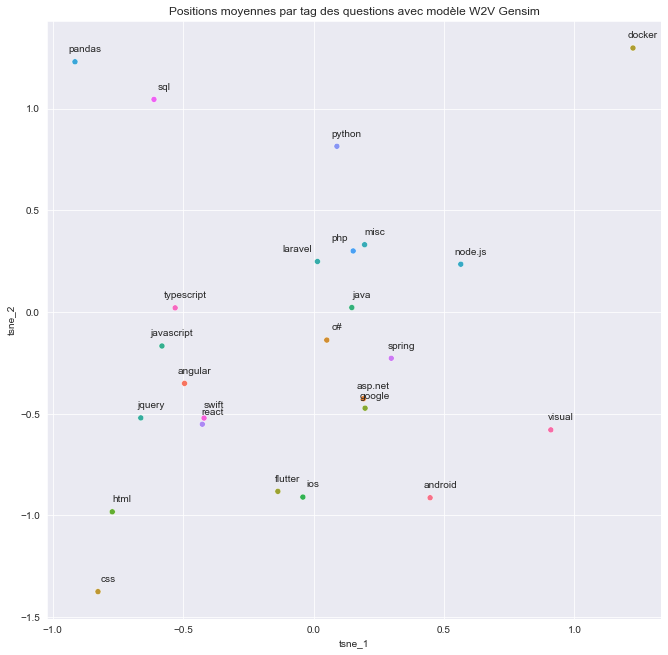

In [103]:
titre = "Positions moyennes par tag des questions avec modèle W2V Gensim"

annotgraph(df_tsne_w2v, df_targ, (11, 11), titre)

**Boucle de modélisation sur réductions PCA**

In [66]:
std = StandardScaler().fit(X_train_w2v)
X_train_w2v_scaled = std.transform(X_train_w2v)
X_test_w2v_scaled = std.transform(X_test_w2v)

Boucle de modélisation sur différents nombres de composants PCA

In [67]:
liste_n = [5, 10, 50, 75, 90, 100]

res = model_pca(liste_n, X_train_w2v_scaled, y_train, X_test_w2v_scaled, y_test)

Meilleur score 0.57 pour PCA avec n = 90 expliquant 100% de la variance en 151 secondes.


C'est notre meilleur résultat jusqu'à maintenant. Procédons à une optimisation bayesiène...

In [69]:
pca = PCA(n_components = 90)
pca.fit(X_train_w2v_scaled)
X_train_w2v_pca = pca.transform(X_train_w2v_scaled)
X_test_w2v_pca = pca.transform(X_test_w2v_scaled)

In [70]:
X_train_w2v_pca.shape

(20000, 90)

**OPTIMISATION**

In [74]:
def bo_m_clas4(max_depth, gamma, n_estimators ,learning_rate, eta):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate,
              'subsample': 0.8,
              'eta': eta, 
              'verbosity': 0, 
              'objective': "reg:logistic",
              'random_state' : 47#, 'eval_metric': 'f1'
             }
    
    # création du model qu'on va utiliser
    xgb_model = xgb.XGBClassifier(**params)
    # création du modèle multilabels
    m_clas = BinaryRelevance(classifier = xgb_model)
    
    m_clas.fit(X_train_w2v_pca, y_train)
    preds = m_clas.predict(X_test_w2v_pca)

    score = f1_score(y_test, preds, average = "weighted")
    
    return score

In [75]:
m_clas_bo4 = BayesianOptimization(bo_m_clas4, 
                                  {'max_depth': (3, 10),
                                   'gamma': (0.01, 0.999),
                                   'eta' : (0.01, 0.1),
                                   'learning_rate':(0.001, 0.999),
                                   'n_estimators':(50, 250)}, 
                                  random_state = 47)

In [76]:
start = time()
m_clas_bo4.maximize(n_iter=10, init_points=5, acq='ucb')
print(f"L'optimization a mis : {time() - start:.0f} secondes.")

|   iter    |  target   |    eta    |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.5671   |  0.02021  |  0.9738   |  0.7283   |  5.46     |  191.5    |
|  2        |  0.5586   |  0.08196  |  0.6485   |  0.4148   |  7.942    |  99.33    |
|  3        |  0.5629   |  0.03304  |  0.03375  |  0.09953  |  5.103    |  178.2    |
|  4        |  0.5626   |  0.039    |  0.1935   |  0.9164   |  4.896    |  104.7    |
|  5        |  0.5963   |  0.0959   |  0.1357   |  0.7468   |  3.037    |  221.4    |
|  6        |  0.5822   |  0.1      |  0.01     |  0.999    |  3.0      |  240.5    |
|  7        |  0.4186   |  0.01     |  0.999    |  0.001    |  10.0     |  224.4    |
|  8        |  0.5549   |  0.07489  |  0.9705   |  0.9877   |  5.107    |  206.2    |
|  9        |  0.5554   |  0.02183  |  0.5817   |  0.8671   |  8.792    |  187.4    |
|  10       |  0.5862   |  0.0868   |  0.1793   |  0.6

In [77]:
best_params_04 = m_clas_bo4.max['params']
best_params_04

{'eta': 0.09589714141586884,
 'gamma': 0.13571631077741386,
 'learning_rate': 0.7467703201796124,
 'max_depth': 3.0366656898923186,
 'n_estimators': 221.35812157287305}

In [78]:
best_params_04['max_depth']= int(best_params_04['max_depth'])
best_params_04['n_estimators']= int(best_params_04['n_estimators'])

In [79]:
xgb_model4 = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47, **best_params_04)
# création du modèle multilabels
m_clas4 = BinaryRelevance(classifier = xgb_model4)

In [80]:
start = time()
m_clas4.fit(X_train_w2v_pca, y_train)
print(f"L'entrainement a pris {time() - start:.0f} secondes")

L'entrainement a pris 194 secondes


In [81]:
pred_04 = m_clas4.predict(X_test_w2v_pca).toarray()
f1_score(y_test, 
         pred_04, 
         average = "weighted")

0.5961856496481222

Encore une fois, on améliore les résultats obtenus jusqu'à présent. Essayons maintenant le word-embedding obtenu grâce à un modèle **FastText**.

In [82]:
# Sauvegardes
pickle_out = open("Data/m_clas4.pickle", "wb")
pickle.dump(m_clas4, pickle_out)
pickle_out.close()

pickle_out = open("Data/best_params_04.pickle", "wb")
pickle.dump(best_params_04, pickle_out)
pickle_out.close()

pickle_out = open("Data/pred_04.pickle", "wb")
pickle.dump(pred_04, pickle_out)
pickle_out.close()

### **5-) Modèle ad-hoc FastText**

**Création d'un modèle FastText pas à pas**

Création du modèle

In [38]:
model_ft = FastText(size=100, window=10, min_count=2, seed = 47)

Création du vocabulaire

In [39]:
model_ft.build_vocab(sentences = feat_train_gens)

Regardons le vecteur d'un mot avant entraînement.

In [85]:
model_ft['bash']

array([-2.4413185e-04, -4.6436209e-03,  1.6983330e-03,  3.6927857e-03,
        1.7164272e-03, -4.7118631e-03,  3.1072025e-03,  4.8524728e-03,
       -8.1262545e-04, -3.8095473e-03,  1.2497412e-03, -4.6072495e-03,
       -1.7519478e-03, -4.7682738e-03,  9.1973183e-05, -1.1011118e-03,
        4.1487394e-03,  1.1862753e-03,  4.9976767e-03, -1.1266258e-03,
        4.5588370e-03, -4.7933403e-03, -1.9303147e-03, -2.7580031e-03,
        5.0129893e-04,  4.3895938e-03, -1.5044528e-03,  2.5775870e-03,
        2.8558872e-03, -1.9079596e-03, -1.2728169e-03, -2.1136357e-03,
       -3.7687735e-03,  4.9733726e-04, -8.2158303e-04, -2.8132519e-03,
       -1.7963051e-03, -2.4820901e-03,  2.6687169e-03, -2.3457860e-03,
        3.3561932e-03, -3.0154462e-03,  2.2650412e-03, -2.2130595e-03,
       -4.7711702e-03, -2.4327363e-03, -2.8532636e-03,  3.5343599e-03,
       -3.6438643e-03,  3.5576965e-03,  1.8383788e-04, -2.3047775e-03,
        1.7664213e-03, -3.5851905e-03, -1.1635149e-03, -1.0919272e-05,
      

Entraînement du modèle

In [40]:
start = time()
model_ft.train(sentences = feat_train_gens, total_examples=len(feat_train_gens), epochs=15)
print(f"L'entrainement a pris {time() - start:.0f} secondes")

L'entrainement a pris 64 secondes


Vecteur du mot "bash" après entraînement...

In [87]:
model_ft['bash']

array([-4.264452  , -0.22475463, -0.6798939 , -1.1425767 , -0.7151687 ,
        0.43066147,  2.7647462 ,  0.83653617,  0.88253874,  2.3862953 ,
       -0.94957596, -3.4297674 , -0.03088828,  1.3999194 ,  1.0941017 ,
        0.5574567 ,  0.24036962, -0.1220824 ,  1.6853569 , -0.62314725,
       -1.2285213 , -3.1366668 , -1.3463801 ,  0.9775131 , -1.9009361 ,
        2.3634133 ,  2.9555817 ,  1.276855  ,  0.34538504, -0.11842585,
       -0.6486669 , -0.9703036 , -5.3995256 ,  3.6658692 , -0.34090784,
        0.42201158,  1.6624131 , -3.350765  , -2.5385492 , -1.8770199 ,
        3.4048188 , -1.6093658 , -1.6537098 , -2.3446763 , -1.5798622 ,
       -0.12456157, -0.6791476 ,  1.4568233 , -2.1711617 ,  3.666011  ,
        2.472118  ,  1.7243441 , -0.29309547, -3.525274  , -2.9301505 ,
        1.3034683 , -3.0330215 , -1.5448323 , -4.3417773 , -1.7727447 ,
        0.57120377, -1.417058  , -2.1858351 ,  1.1049399 , -3.4652884 ,
       -0.33381957, -2.2226858 , -1.6275798 , -1.4392229 , -1.07

Modélisation de nos données avec le modèle FastText entraîné

In [88]:
X_train_ft = make_gensim_vectors(feat_train_gens, model_ft)

# Fast text gère les "nouveaux mots" absents de son vocabulaire initial...
# inutile de nettoyer les données test du vocabulaire manquant...
X_test_ft = make_gensim_vectors(feat_test_gens, model_ft)

In [90]:
# Sauvegardes des données et du modèle FastText
model_ft.save("Data/model_ft.bin")

pickle_out = open("Data/X_train_ft.pickle", "wb")
pickle.dump(X_train_ft, pickle_out)
pickle_out.close()

pickle_out = open("Data/X_test_ft.pickle", "wb")
pickle.dump(X_test_ft, pickle_out)
pickle_out.close()

**Représentation graphique**

In [104]:
df_coord_ft = pd.DataFrame(X_train_ft)

df_targ = pickle.load(open("Data/df_targ.pickle", "rb"))

df_tsne_ft = c_tsne(df_coord_ft, 60)

# Sauvegarde
pickle_out = open("Data/df_tsne_ft.pickle", "wb")
pickle.dump(df_tsne_ft, pickle_out)
pickle_out.close()

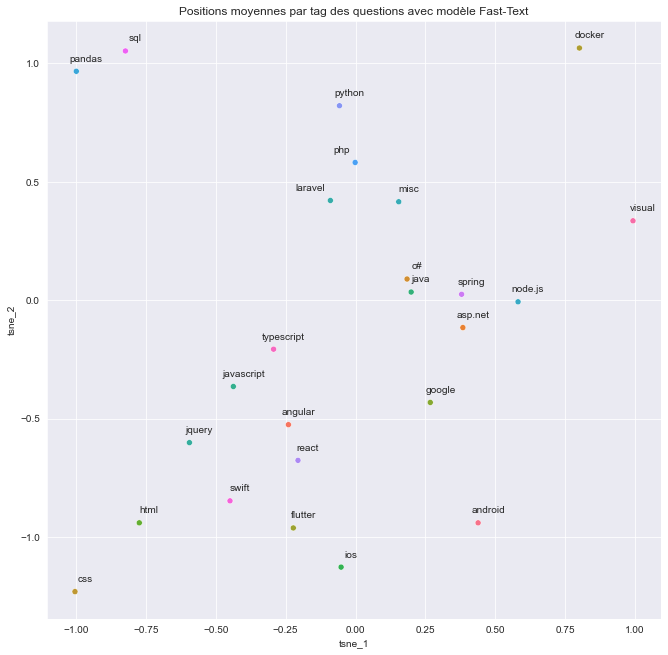

In [105]:
titre = "Positions moyennes par tag des questions avec modèle Fast-Text"

annotgraph(df_tsne_ft, df_targ, (11, 11), titre)

**Boucle de modélisation sur réductions PCA**

In [257]:
std = StandardScaler().fit(X_train_ft)
X_train_ft_scaled = std.transform(X_train_ft)
X_test_ft_scaled = std.transform(X_test_ft)

In [93]:
liste_n = [5, 10, 50, 75, 90, 100]

res = model_pca(liste_n, X_train_ft_scaled, y_train, X_test_ft_scaled, y_test)

Meilleur score 0.60 pour PCA avec n = 75 expliquant 99% de la variance en 132 secondes.


Résultats toujours plus encourageants...<br>On passe à l'optimisation...

In [258]:
pca = PCA(n_components = 75)
pca.fit(X_train_ft_scaled)
X_train_ft_pca = pca.transform(X_train_ft_scaled)
X_test_ft_pca = pca.transform(X_test_ft_scaled)

In [259]:
# sauvegardes
pickle_out = open("Data/std.pickle", "wb")
pickle.dump(std, pickle_out)
pickle_out.close()

pickle_out = open("Data/pca.pickle", "wb")
pickle.dump(pca, pickle_out)
pickle_out.close()

pickle_out = open("Data/X_train_ft_pca.pickle", "wb")
pickle.dump(X_train_ft_pca, pickle_out)
pickle_out.close()

pickle_out = open("Data/X_test_ft_pca.pickle", "wb")
pickle.dump(X_test_ft_pca, pickle_out)
pickle_out.close()

In [62]:
X_train_ft_pca = pickle.load(open("Data/X_train_ft_pca.pickle", "rb"))

In [95]:
def bo_m_clas5(max_depth, gamma, n_estimators ,learning_rate, eta):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate,
              'subsample': 0.8,
              'eta': eta, 
              'verbosity': 0, 
              'objective': "reg:logistic",
              'random_state' : 47#, 'eval_metric': 'f1'
             }
    
    # création du model qu'on va utiliser
    xgb_model = xgb.XGBClassifier(**params)
    # création du modèle multilabels
    m_clas = BinaryRelevance(classifier = xgb_model)
    
    m_clas.fit(X_train_ft_pca, y_train)
    preds = m_clas.predict(X_test_ft_pca)

    score = f1_score(y_test, preds, average = "weighted")
    
    return score

In [96]:
m_clas_bo5 = BayesianOptimization(bo_m_clas5, 
                                  {'max_depth': (3, 10),
                                   'gamma': (0.01, 0.999),
                                   'eta' : (0.01, 0.1),
                                   'learning_rate':(0.001, 0.999),
                                   'n_estimators':(50, 250)}, 
                                  random_state = 47)

In [97]:
start = time()
m_clas_bo5.maximize(n_iter=10, init_points=5, acq='ucb')
print(f"L'optimization a mis : {time() - start:.0f} secondes.")

|   iter    |  target   |    eta    |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.5968   |  0.02021  |  0.9738   |  0.7283   |  5.46     |  191.5    |
|  2        |  0.5928   |  0.08196  |  0.6485   |  0.4148   |  7.942    |  99.33    |
|  3        |  0.5941   |  0.03304  |  0.03375  |  0.09953  |  5.103    |  178.2    |
|  4        |  0.5996   |  0.039    |  0.1935   |  0.9164   |  4.896    |  104.7    |
|  5        |  0.617    |  0.0959   |  0.1357   |  0.7468   |  3.037    |  221.4    |
|  6        |  0.6171   |  0.09751  |  0.8148   |  0.6484   |  3.22     |  220.9    |
|  7        |  0.435    |  0.01     |  0.999    |  0.001    |  10.0     |  238.7    |
|  8        |  0.5874   |  0.02378  |  0.7569   |  0.3278   |  9.823    |  130.0    |
|  9        |  0.6162   |  0.0449   |  0.1539   |  0.5212   |  3.015    |  208.1    |
|  10       |  0.587    |  0.03434  |  0.6594   |  0.9

In [98]:
best_params_05 = m_clas_bo5.max['params']

best_params_05['max_depth']= int(best_params_05['max_depth'])
best_params_05['n_estimators']= int(best_params_05['n_estimators'])

In [60]:
xgb_model5 = xgb.XGBClassifier(objective = "reg:logistic", random_state = 47, **best_params_05)
# création du modèle multilabels
m_clas5 = BinaryRelevance(classifier = xgb_model5)

In [64]:
start = time()
m_clas5.fit(X_train_ft_pca, y_train)
print(f"L'entrainement a pris {time() - start:.0f} secondes")

L'entrainement a pris 184 secondes


In [65]:
pred_05 = m_clas5.predict(X_test_ft_pca).toarray()
f1_score(y_test, 
         pred_05, 
         average = "weighted")

0.6096856090636585

Il s'agit du meilleur résultat obtenu.<br>De toutes les options essayées, la modélisation **FastText**, réputée pour son efficacité dans les cas où l'on entraîne son propre modèle sur une quantité modérée de données, est la meilleure.

In [106]:
# Sauvegardes
pickle_out = open("Data/m_clas5.pickle", "wb")
pickle.dump(m_clas5, pickle_out)
pickle_out.close()

pickle_out = open("Data/best_params_05.pickle", "wb")
pickle.dump(best_params_05, pickle_out)
pickle_out.close()

pickle_out = open("Data/xgb_model5.pickle", "wb")
pickle.dump(xgb_model5, pickle_out)
pickle_out.close()

pickle_out = open("Data/pred_05.pickle", "wb")
pickle.dump(pred_05, pickle_out)
pickle_out.close()

pickle_out = open("Data/m_clas5.pickle", "wb")
pickle.dump(m_clas5, pickle_out)
pickle_out.close()

# **3-) Recours au Deep Learning**

Notre projet a été rendu plus compliqué par son cadre de classification multi-label.<br><br>Or, il s'avère que le **deep learning** gère **nativement** le multi-label pour peu qu'on respecte certaines conditions, à savoir que la couche de sortie :<br>- dispose d'autant de neurones qu'on a de labels<br>- ait une activation **sigmoïde**.<br><br>Nous allons donc tester un **réseau de neurones** sur les données à partir desquelles nous avons obtenus les meilleurs résultats, celle du modèle **Fast-Text** réduites par PCA à 75 dimensions.

In [34]:
# chargement des données
X_train_ft_pca = pickle.load(open("Data/X_train_ft_pca.pickle", "rb"))
X_test_ft_pca = pickle.load(open("Data/X_test_ft_pca.pickle", "rb"))

y_train = pickle.load(open("Data/y_train.pickle", "rb"))
y_train = y_train.toarray()
y_test = pickle.load(open("Data/y_test.pickle", "rb"))
y_test = y_test.toarray()

Fonctions utilisées pour cette modélisation :

In [35]:
def model_nn(model, epoch, save):
    """
    Fonction de modélisation à l'aide d'un réseau neuronal.
    """
    checkpoint = ModelCheckpoint(filepath = save, 
                                 monitor = "val_accuracy",
                                 verbose = 1,
                                 save_best_only = True)
    
    history = model.fit(X_train_ft_pca, 
                        y_train,
                        epochs = epoch,
                        batch_size = 32,
                        validation_split = 0.2,
                        callbacks = [checkpoint])
    
    val_acc = history.history['val_accuracy'][-1]
    
    preds = model.predict(X_test_ft_pca)
    
    pred = preds.round()
    
    f1_sc = f1_score(y_test,
                     pred,
                     average = "weighted")
    
    return val_acc, f1_sc 

In [36]:
def loop(liste_ep, model, save):
    """
    Fonction permettant d'opérer une boucle de modélisations à partir d'une liste de nombre d'epochs
    d'entraînement.
    """
    
    start = time()
    vals = []
    f1s = []
    
    for ep in tqdm(liste_ep) :
    
        res = model_nn(model, ep, save)
        vals.append(res[0])
        f1s.append(res[1])
        
    temps = time() - start
        
    return vals, f1s, res, temps

In [37]:
def graph(liste_ep, vals, f1s) :
    """
    Fonction permettant d'afficher un graphique à partir des données recueillies après une boucle de
    modélisations.
    """
    
    fig = plt.figure(figsize = (7,4))
    
    plt.plot(liste_ep, vals, 'b', label='Validation acc', color = "red")
    plt.plot(liste_ep, f1s, 'b', label='F1 weighted', color = "blue")
    plt.title('Val. Accuracy et test F1 Score')
    plt.xlabel("Epochs")
    plt.ylabel("Scores")
    plt.legend()
    plt.show()

### **Modélisation**

Création du modèle

In [67]:
def create_model():
    
    model = Sequential()

    model.add(Dense(75, input_shape = (75, )))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    model.add(Dense(75))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    model.add(Dense(25))
    model.add(Activation("sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics="accuracy")
    
    return model

In [76]:
model_1 = create_model()

model_1.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 75)                5700      
_________________________________________________________________
activation_75 (Activation)   (None, 75)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 75)                5700      
_________________________________________________________________
activation_76 (Activation)   (None, 75)                0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 25)              

**Boucle de modélisation en fonction du nombre d'epochs**

In [77]:
liste_ep1 = [1, 5, 10, 15, 20, 25, 30, 40, 50]
vals, f1s, res, temps = loop(liste_ep1, model_1, "so_dl_01.hdf5")

  0%|          | 0/9 [00:00<?, ?it/s]

420/500 [========================>.....] - ETA: 0s - loss: 0.1979 - accuracy: 0.3175
Epoch 00001: val_accuracy improved from -inf to 0.55325, saving model to so_dl_01.hdf5
500/500 [==============================] - 0s 926us/step - loss: 0.1862 - accuracy: 0.3457 - val_loss: 0.1041 - val_accuracy: 0.5533
Epoch 1/5
476/500 [===========================>..] - ETA: 0s - loss: 0.1089 - accuracy: 0.5389
Epoch 00001: val_accuracy improved from -inf to 0.60400, saving model to so_dl_01.hdf5
500/500 [==============================] - 0s 828us/step - loss: 0.1088 - accuracy: 0.5400 - val_loss: 0.0895 - val_accuracy: 0.6040
Epoch 2/5
472/500 [===========================>..] - ETA: 0s - loss: 0.0975 - accuracy: 0.5771
Epoch 00002: val_accuracy improved from 0.60400 to 0.62825, saving model to so_dl_01.hdf5
500/500 [==============================] - 0s 782us/step - loss: 0.0973 - accuracy: 0.5776 - val_loss: 0.0845 - val_accuracy: 0.6283
Epoch 3/5
477/500 [===========================>..] - ETA: 0s -

Durée de la boucle d'entrainements : 71.65409851074219
 Meilleur score : 0.6947982990421135, pour nb epochs : 20



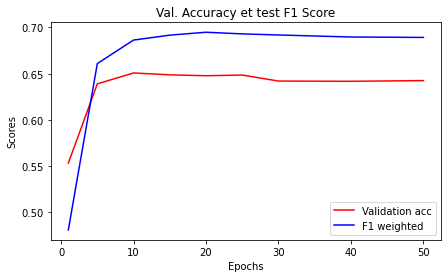

In [78]:
#avec 2dropout
print(f"Durée de la boucle d'entrainements : {temps}")
print(f" Meilleur score : {np.max(np.array(f1s))}, pour nb epochs : {liste_ep1[np.argmax(np.array(f1s))]}")
print()
graph(liste_ep1, vals, f1s)

**Création du modèle optimal :**

In [79]:
# Instanciation du modèle en récupérant les "poids" optimaux
trained_model = create_model()
trained_model.load_weights("so_dl_01.hdf5")

# Prévisions obtenues sur notre échantillon test avec ce modèle
preds = trained_model.predict(X_test_ft_pca)
preds = preds.round()

# Calcul du F1_Score weighted
f1_sc = f1_score(y_test,
                 preds,
                 average = "weighted")
f1_sc

0.6914259717160915

Ce résultat sera le résultat définitif de ce projet.<br>Il nous montre qu'en plus de gérer sans douleur le **multi-label**, le **deep-learning** nous permet de dépasser tous les résultats obtenus jusqu'alors, et ce du premier coup, avec un **réseau de neurones** très basique.<br><br>Si on souhaite poursuivre et améliorer ce projet, la voie est toute tracée. C'est d'abord peut-être celle de **réseaux denses** plus approfondis, mais surtout aussi celle des réseaux adaptés au **NLP** que sont par exempls les **LSTM**, si toutefois la récente technologie **BERT** ne les a pas mis hors-jeux... 